In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
# Full display of notebook (width of screen)
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import basic libraries
import os, glob, sys
import numpy as np   
import pandas as pd 

# Define librearies needed for analysis
import matplotlib.pyplot as plt # Matplotlibrary
import seaborn as sns # Seaborn Library

from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

feat_path = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))))
if feat_path not in sys.path:
    sys.path.append(feat_path)
    
%load_ext autoreload
%autoreload 2

np.random.seed(42)

# use xkcd plotting
plt.xkcd()  

# Define path where data is located and folder to access to it
path_data = os.path.join('../../data','external')

In [2]:
def load_data(path):
    """Load training and testing datasets based on their path

    Parameters
    ----------
    path : relative path to location of data, should be always the same (string)
    
    Returns
    -------
    Training and testing Dataframes
    """
    train = pd.read_csv(os.path.join(path,'train.csv'))
    test = pd.read_csv(os.path.join(path,'test.csv'))
    
    return train, test

# load data in pd dataframe
train, test = load_data(path_data)
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
# Preliminary: count NaN entries --> something to keep in mind
train.isnull().sum(axis = 0)

# comments
# **Age**, **Cabin** and **Embarked** have missing values --> remove or complete

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# Check how many unique values each feature has:
for column in train.columns:
    print("{}: {}".format(column, len(train[column].unique())))

PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 89
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 148
Embarked: 4


In [5]:
# comments
# Features such as: Name, Ticket and Cabin are features with high cardinality. 
# Normally these features can be dropped from dataset. However, sometimes 
# they have usefull information hidden and therefore, before dropping them, 
# we could try to extract that information

# 1. First check on features

## 1.1 Numerical

In [6]:
train.select_dtypes(include=[np.number]).info()
# comments
# within numerical features, only **Age** seems to be incomplete

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


### 1.1.1 PassengerId

In [7]:
# comments
# unique index per passanger --> not needed for training/predictions, 
# but needs to be kept for final submission

### 1.1.2 Survived

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


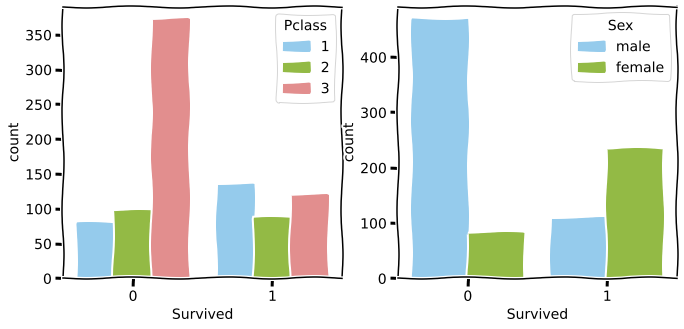

In [8]:
# feature: 'Survived' (Target: about the Survival of people, 0 = No, 1 = Yes)
colors = ['lightskyblue', 'yellowgreen', 'lightcoral']

f, axes = plt.subplots(1, 2,figsize=(11,5))
sns.countplot(x='Survived', hue='Pclass', data=train, palette=colors, ax=axes[0])
sns.countplot(x='Survived', hue='Sex', data=train, palette=colors, ax=axes[1])
plt.show()

# commnets:
# Woman survived more than man
# First class also survived more than other classes
# All together: if women is from 1st and 2nd classes, it has a lot chance to survive above 92%

In [9]:
pd.DataFrame(train.groupby(['Pclass','Sex'])['Survived'].mean()*100)

Survived
Pclass Sex              
1      female  96.808511
       male    36.885246
2      female  92.105263
       male    15.740741
3      female  50.000000
       male    13.544669

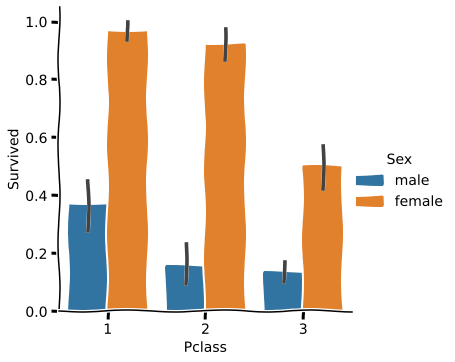

In [10]:
sns.catplot(x='Pclass',y='Survived',data=train,kind='bar',hue='Sex')
plt.show()

### 1.1.3 Pclass

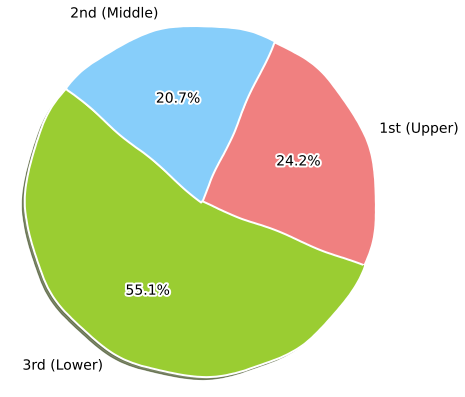

In [11]:
# feature: 'Pclass' (about the Ticket class, a proxy for socio-economic status (SES))
pclass_dic  = {1: "1st (Upper)", 2: "2nd (Middle)", 3: "3rd (Lower)" }
sizes  = train["Pclass"].value_counts().values
labels = [pclass_dic[i] for i in train["Pclass"].value_counts().index.tolist() ]
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'gold' ]

# Plot
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# commnets:
# majority of people comes from 3rd class

### 1.1.4 Age

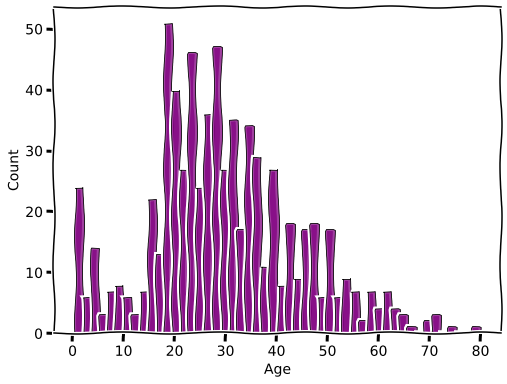

In [12]:
# feature: 'Age' (Age in years, age is fractional if less than 1. 
#                 If the age is estimated, is it in the form of xx.5)
plt.figure(figsize=(8,6))
sns.histplot(x = "Age", data = train, bins=50, color="purple")
plt.show()
# commnets:
# 177 missing values
# right skewed
# useful to try to relate ages with titles, sex?

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


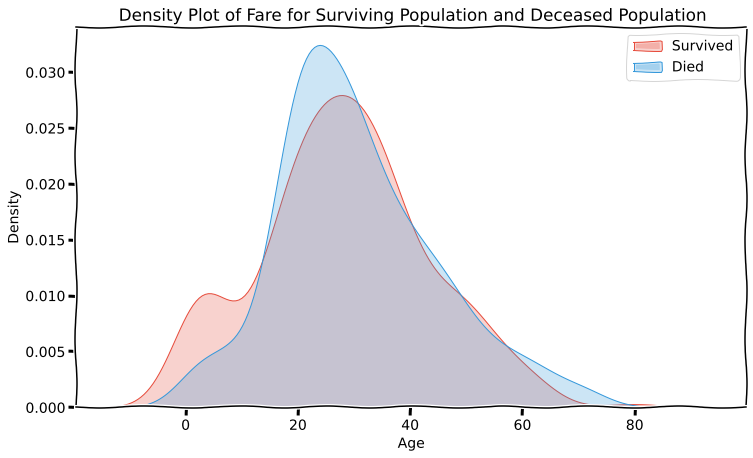

In [13]:
plt.figure(figsize=(12,7))
sns.kdeplot(train["Age"][train.Survived == 1], color="#e74c3c", shade=True)
sns.kdeplot(train["Age"][train.Survived == 0], color="#3498db", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
# limit x axis to zoom on most information. there are a few outliers in fare. 
plt.show()

# commnets:
# childrens indeed population looked after

In [14]:
pd.DataFrame(train.groupby(['Pclass','Sex'])['Age'].describe())

count       mean        std   min     25%   50%    75%   max
Pclass Sex                                                                 
1      female   85.0  34.611765  13.612052  2.00  23.000  35.0  44.00  63.0
       male    101.0  41.281386  15.139570  0.92  30.000  40.0  51.00  80.0
2      female   74.0  28.722973  12.872702  2.00  22.250  28.0  36.00  57.0
       male     99.0  30.740707  14.793894  0.67  23.000  30.0  36.75  70.0
3      female  102.0  21.750000  12.729964  0.75  14.125  21.5  29.75  63.0
       male    253.0  26.507589  12.159514  0.42  20.000  25.0  33.00  74.0

### 1.1.5 SibSp and Parch, FamilySize

In [15]:
# feature: 'SibSp' (# of siblings / spouses aboard the Titanic)
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)

# feature: 'Parch' (# of parents / children aboard the Titanic) 
# The dataset defines family relations in this way:
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them
import string 
def get_size_family(df, mod: bool = False):
    """Defines family relations based on the features 'SibSp' (the # of siblings / spouses aboard the Titanic)
    and 'Parch' (the # of parents / children aboard the Titanic)

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    Original dataframe with a new feature called 'FamilySize'
    """
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    if mod:
        
        bins_ = [0, 1, 3, 4, 5, 12]
        df['FamilySize'] = pd.cut(df["FamilySize"],  bins = bins_, labels = list(string.ascii_uppercase)[:len(bins_)-1])
        
    return df


# get Size family
train = get_size_family(train)

In [16]:
pd.DataFrame(train.groupby(['FamilySize'])['Survived'].mean()*100)

,Survived
FamilySize,
1,30.353818
2,55.279503
3,57.843137
4,72.413793
5,20.000000
6,13.636364
7,33.333333
8,0.000000
11,0.000000


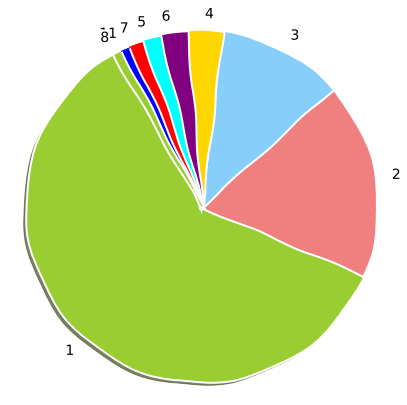

In [17]:
sizes   = train["FamilySize"].value_counts().values
labels  = train["FamilySize"].value_counts().index.tolist()
colors  = ['yellowgreen', 'lightcoral', 'lightskyblue', 'gold', 'purple', 'cyan', 'red', 'blue' ]
#explode = (0.1, 0, 0, 0, 0, 0.15, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
# Plot
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, colors=colors,  #autopct='%1.1f%%', 
        shadow=True, startangle=120)
plt.axis('equal')
plt.show()

# commnets:
# majority of people were alone

In [18]:
# get Size family
train = get_size_family(train, mod = True) # returns categories
pd.DataFrame(train.groupby(['FamilySize'])['Survived'].mean()*100)

,Survived
FamilySize,
A,30.353818
B,56.273764
C,72.413793
D,20.000000
E,14.893617


### 1.1.6 Fare

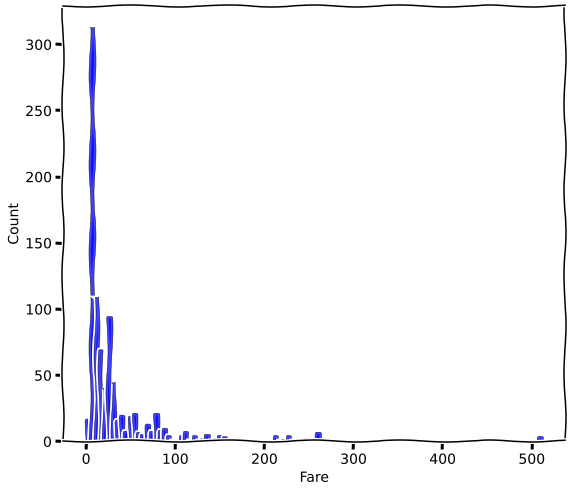

In [19]:
# feature: 'Fare' (Passenger fare)
plt.figure(figsize=(9,8))
sns.histplot(x ="Fare", data = train, color="blue")
plt.show()
# commnets:
# only minority of fare are above 200 dollars -> bin into categories instead of continuous

In [20]:
pd.DataFrame(train.groupby(['Pclass'])['Fare'].median())

,Fare
Pclass,
1,60.2875
2,14.2500
3,8.0500


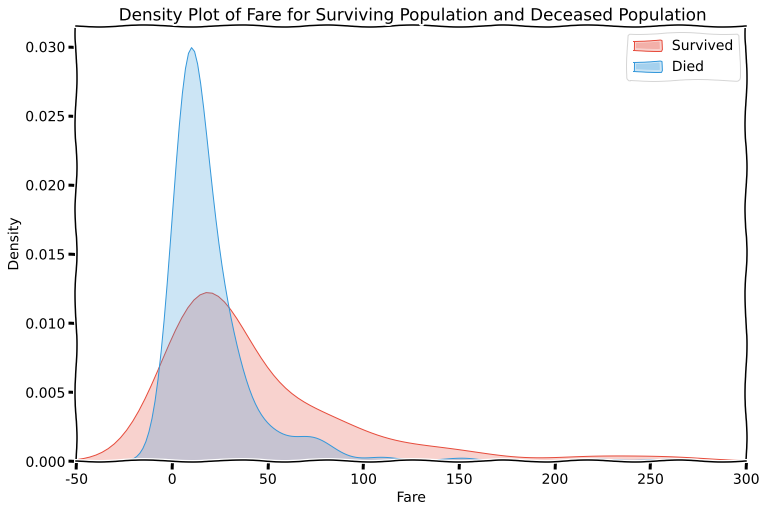

In [21]:
plt.figure(figsize=(12,8))
sns.kdeplot(train["Fare"][train.Survived == 1], color="#e74c3c", shade=True)
sns.kdeplot(train["Fare"][train.Survived == 0], color="#3498db", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
plt.xlim(-50,300)
plt.show()

In [22]:
def modify_fare(df, n: int = 4, extra: bool = False):
    """Introduce n new intervals (based on quantiles) for the feature fare, such that it is modified from
    being continuous to being discrete

    Parameters
    ----------
    df : panda dataframe
    n: number of new intervals (int)
    
    Returns
    -------
    Original dataframe with discretized version of the feature 'Fare', categories
    """
    #df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
    if extra:
        
        df['Fare_num'] = df['Fare']
        
    df['Fare'] = pd.qcut(df['Fare'], n, labels = list(string.ascii_uppercase)[:n])
    
    return df

# produce intervals
train = modify_fare(train, 4, True) # returns categories

pd.DataFrame(train.groupby(['Fare'])['Survived'].mean())

,Survived
Fare,
A,0.197309
B,0.303571
C,0.454955
D,0.581081


In [23]:
train['Fare'].value_counts()

B    224
A    223
C    222
D    222
Name: Fare, dtype: int64

## 1.2 Categorical

In [24]:
train.select_dtypes(exclude=[np.number]).info()

# comments
# **Cabin** seems to be incomplete
# **Embarked** seems to have 2 missing entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        891 non-null    object  
 1   Sex         891 non-null    object  
 2   Ticket      891 non-null    object  
 3   Fare        891 non-null    category
 4   Cabin       204 non-null    object  
 5   Embarked    889 non-null    object  
 6   FamilySize  891 non-null    category
dtypes: category(2), object(5)
memory usage: 37.1+ KB


In [25]:
train.select_dtypes(exclude=[np.number]).keys()

Index(['Name', 'Sex', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize'], dtype='object')

In [26]:
# feature: 'Name' 
train['Name'][:5]

# commnets:
# * About the sociaty title
#  Hypothesis: can have hidden information about passenger status. 
#  rich  people may have greater changes of survival
# * family survival rate: a lot of people survived from specific family increases chances of 
#   person from same family to survive
# Feature 'Name' has following structure:
# Family name--> "," --> Title --> Name --> "(" --> some name in bracket.
# In data: unique titles: 
# Mr. Mrs. Miss. Don. Master. Rev. Mme. Dr. Col. Capt. Countess. Lady. Dona. Major. Mlle. Mme.
#   --> use to proxy family/status
# e.g. Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg) --> proxy for married people, siblings ?

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [27]:
train[1:2]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Fare_num
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,D,C85,C,B,71.2833


In [28]:
# 'Mrs', 'Mr', 'Master', 'Dr'
# 'Miss' = is a title used generally by unmarried women
# 'Don'= derived from the Latin Dominus; it means a master of a household. It is an honorific prefix primarily used in Italy, Spain, Portugal, Latin America, Croatia, Goa, and the Philippines
# 'Mme' = short for Madame (French for, Madam)
# 'Ms' =  is a title used by women regardless of their marital status
# 'Major' = is a mil**itary rank of commissioned officer status
# 'Col' = Colonel is conferred by some states in the United States of America
# 'Jonkheer' = is [](http://)a male honorific for Dutch nobility
# 'Mlle' = Mademoiselle is a French courtesy title, abbreviated Mlle, traditionally given to an unmarried woman 
# 'Rev' = Reverend (placed before the names of Christian clergy and ministers)
# 'Capt' = Captain
# 'Countess' =  is a historical title of nobility in certain European countries

In [29]:
import re

def get_title(name):
    """Search for individual title in a string by considering it to have a ASCII format from  A-Z

    Parameters
    ----------
    name : The name from which a title wants to be extracted (string)
    
    Returns
    -------
    String associated to a found title
    """
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)

    return ""

# e.g.
print("""Full testing name for function: '{}' """.format(train['Name'][0]))
print("""Definition used leads to: '{}' """.format(get_title(train['Name'][0])))

Full testing name for function: 'Braund, Mr. Owen Harris' 
Definition used leads to: 'Mr' 


In [30]:
def get_titles(df, mod: bool = True):
    """Search for all titles inside a dataframe, given the feature 'Name'

    Parameters
    ----------
    df : panda dataframe
    mod : simplify the extend of titles available (boolean)
    
    Returns
    -------
    Original dataframe with a new feature called 'Title'
    """
    df['Title'] = df['Name'].apply(get_title)
    if mod:
        # perform modifications
        df['Title'] = df['Title'].replace('Mlle', 'Miss')
        df['Title'] = df['Title'].replace('Ms', 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')

    return df

# Create a new feature Title, containing the titles of passenger names
train = get_titles(train, True)

In [31]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


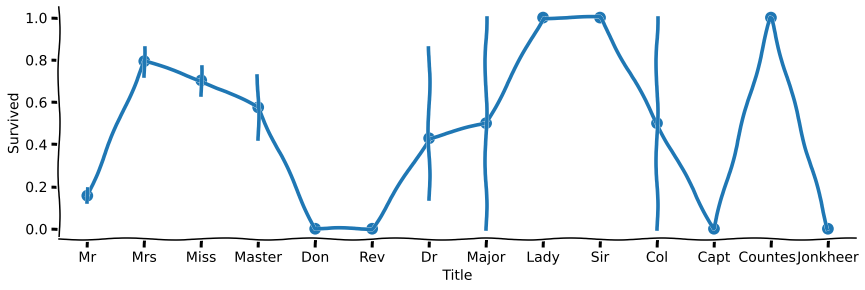

In [32]:
sns.factorplot('Title','Survived', data=train,size=4,aspect=3)
plt.show()

### Ages further exploration

In [33]:
# Mean by title and its std
emb0 = []
for i, row in train[train.Survived == 0].iterrows():
    if pd.isnull(row['Age']):
        title = row['Title']
        age_avg = train['Age'][train['Title'] == title].mean()
        age_std = train['Age'][train['Title'] == title].std()
        emb0.append(np.random.randint(age_avg - age_std, age_avg + age_std, size=1)[0])
    else:
        emb0.append(row['Age'])
        
emb1 = []
for i, row in train[train.Survived == 1].iterrows():
    if pd.isnull(row['Age']):
        title = row['Title']
        age_avg = train['Age'][train['Title'] == title].mean()
        age_std = train['Age'][train['Title'] == title].std()
        emb1.append(np.random.randint(age_avg - age_std, age_avg + age_std, size=1)[0])
    else:
        emb1.append(row['Age'])
        
# Mean by MICE
# https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
from fancyimpute import IterativeImputer

mice_impute = IterativeImputer()
bip0 = mice_impute.fit_transform(train["Age"][train.Survived == 0].values.reshape(-1, 1))
bip1 = mice_impute.fit_transform(train["Age"][train.Survived == 1].values.reshape(-1, 1))

bip0 = bip0.flatten(order='C')
bip1 = bip1.flatten(order='C')

# Mean by Pclass, Sex and their std
emb0_T0 = []
for i, row in train[train.Survived == 0].iterrows():
    if pd.isnull(row['Age']):
        clas = row['Pclass']
        sex = row['Sex']
        age_avg = train['Age'][(train['Pclass'] == clas) & (train['Sex'] == sex)].mean()
        age_std = train['Age'][(train['Pclass'] == clas) & (train['Sex'] == sex)].std()
        emb0_T0.append(np.random.randint(age_avg - age_std, age_avg + age_std, size=1)[0])
    else:
        emb0_T0.append(row['Age'])
        
emb0_T1 = []
for i, row in train[train.Survived == 1].iterrows():
    if pd.isnull(row['Age']):
        clas = row['Pclass']
        sex = row['Sex']
        age_avg = train['Age'][(train['Pclass'] == clas) & (train['Sex'] == sex)].mean()
        age_std = train['Age'][(train['Pclass'] == clas) & (train['Sex'] == sex)].std()
        emb0_T1.append(np.random.randint(age_avg - age_std, age_avg + age_std, size=1)[0])
    else:
        emb0_T1.append(row['Age'])
        
print("ready to go!")

ready to go!


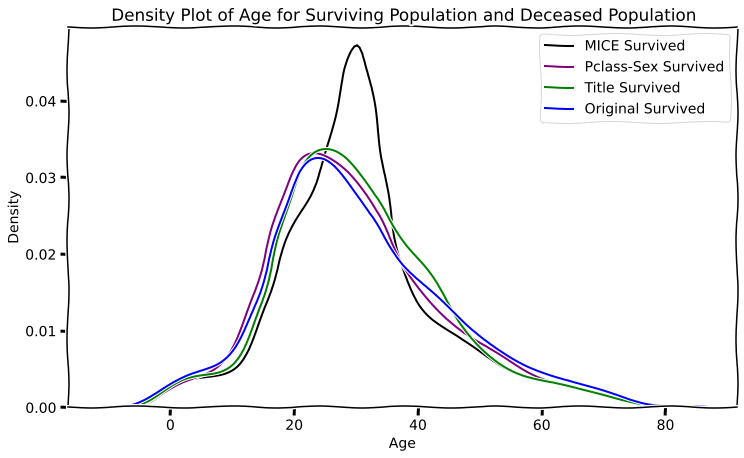

In [34]:
plt.figure(figsize=(12,7))
sns.kdeplot(bip0, color="black", shade=False)
sns.kdeplot(emb0_T0, color="purple", shade=False)
sns.kdeplot(emb0, color="green", shade=False)
sns.kdeplot(train["Age"][train.Survived == 0], color="blue", shade=False)
plt.legend(['MICE Survived', 'Pclass-Sex Survived', 'Title Survived', 'Original Survived'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
# limit x axis to zoom on most information. there are a few outliers in fare. 
plt.show()

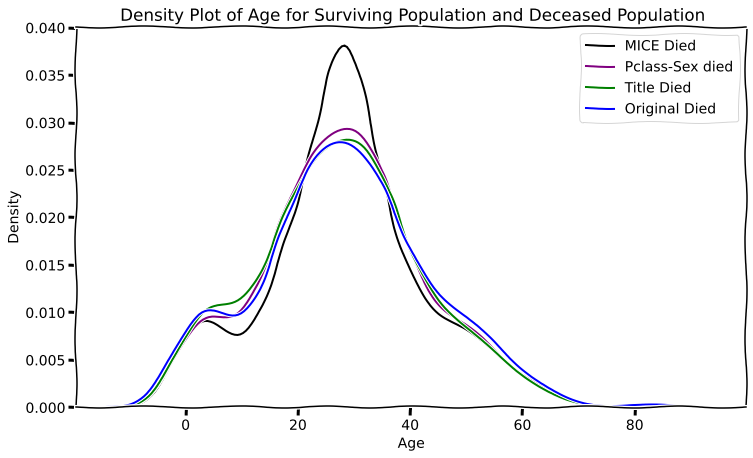

In [35]:
plt.figure(figsize=(12,7))
sns.kdeplot(bip1, color="black", shade=False)
sns.kdeplot(emb0_T1, color="purple", shade=False)
sns.kdeplot(emb1, color="green", shade=False)
sns.kdeplot(train["Age"][train.Survived == 1], color="blue", shade=False)
plt.legend(['MICE Died', 'Pclass-Sex died', 'Title Died', 'Original Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
# limit x axis to zoom on most information. there are a few outliers in fare. 
plt.show()

In [36]:
import scipy.stats

def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """
    if len(p)>len(q):
        p = np.random.choice(p,len(q))
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

#jensen_shannon_distance(np.array([1.0, 0.0, 0.0]), np.array([1.0, 0.0, 0.0])) = 0.0

agesSu = { 'MICE Survived'       : bip0,  
           'Class-Sex Survived': emb0_T0,
           'Title Survived':    emb0 }

for name, fil in agesSu.items():
    
    print("{}: {:.3f}".format(name, jensen_shannon_distance(train["Age"][(train.Survived == 0)& (~np.isnan(train["Age"]))], fil)))

print("")
agesDi = { 'MICE died'       : bip1, 
           'Class-Sex died': emb0_T1, 
           'Title died':     emb1 }

for name, fil in agesDi.items():
    
    print("{}: {:.3f}".format(name, jensen_shannon_distance(train["Age"][(train.Survived == 1)& (~np.isnan(train["Age"]))], fil)))

MICE Survived: 0.231
Class-Sex Survived: 0.239
Title Survived: 0.232

MICE died: 0.267
Class-Sex died: 0.282
Title died: 0.307


In [37]:
def drop_features(df, to_drop):
    """Drop unwanted features 

    Parameters
    ----------
    df      : panda dataframe
    to_drop : array with name of features to be dropped
    
    Returns
    -------
    Original dataframe with all original features but those in to_drop
    """
    return df.drop(to_drop, axis=1)

def get_missing_ages(df, extra: bool = False):
    """Fills in empty Ages based on the Title of a person. If Extra is True, calculate
       the empty Ages considering the PClass and Sex.

    Parameters
    ----------
    df   : panda dataframe
    extra: number of new intervals (boolean)
    
    Returns
    -------
    Complete version the feature 'Age'
    """
    emb = []
    for i, row in df.iterrows():
        if pd.isnull(row['Age']):
            title   = row['Title']
            age_avg = df['Age'][df['Title'] == title].mean()
            age_std = df['Age'][df['Title'] == title].std()
            emb.append(np.random.randint(age_avg - age_std, age_avg + age_std, size=1)[0])
        else:
            emb.append(row['Age'])
    # Update column
    df['Age_t'] = emb
    
    if extra: 
        emb_T = []
        for i, row in df.iterrows():
            if pd.isnull(row['Age']):
                clas = row['Pclass']
                sex  = row['Sex']
                age_avg = df['Age'][(df['Pclass'] == clas) & (df['Sex'] == sex)].mean()
                age_std = df['Age'][(df['Pclass'] == clas) & (df['Sex'] == sex)].std()
                emb_T.append(np.random.randint(age_avg - age_std, age_avg + age_std, size=1)[0])
            else:
                emb_T.append(row['Age'])
        # Update column
        df['Age_ps'] = emb_T
        
    df = drop_features(df, ['Age'])

    return df

def get_ages_binned(df, key, n: int = 5):
    """Introduces n intervals for the feature given in keys, such that it is modified 
       from being continuous to be discrete

    Parameters
    ----------
    df  : panda dataframe
    key : specific Age key to modify. e.g. 'Age_t' (or could be 'Age_ps')
    n   : number of new intervals (int)
    
    Returns
    -------
    Discretized version of the feature specified by key, categories
    """

    # Create new column
    df["{}_num".format(key)] = df[key]
    
    df[key] = pd.cut(df[key], n, labels = list(string.ascii_uppercase)[:n])

    return df

# Add missing ages by title
train = get_missing_ages(train, True)       # numerical
train = get_ages_binned(train, 'Age_t', 5) # returns categories
train = get_ages_binned(train, 'Age_ps', 5) # returns categories

In [38]:
def modify_titles(df):
    """Concatenates titles found to be similar or considered to be simplified in one category

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    Simplified categories in the features 'Title'
    """
    # join less representative cotegories
    df['Title'] = df['Title'].replace(['Lady', 'Countess',
                                       'Capt', 'Col', 'Don', 'Dr', 'Major',
                                       'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    return df

# Simplify categories titles
train = modify_titles(train) # modify titles still into categories

# inspect reduced version
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


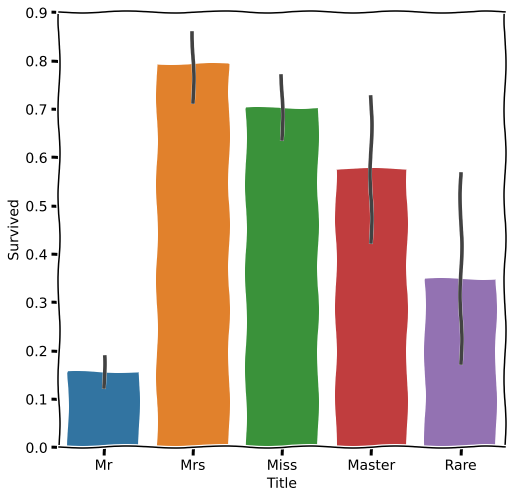

In [39]:
# According to the plot there is definatelly correlation between survival rate and title.
# Most of this correlation comes from gender, however, gender information provides less 
# information by itself. For example Mrs and Miss have the same gender, but it is visible 
# that Mrs has higher survival rate than Miss.

# visualize title vs survival rate:
sns.barplot(x = 'Title', y = 'Survived', data = train)
plt.show()

In [40]:
pd.DataFrame(train.groupby(['Title'])['Survived'].mean()).sort_values(by='Survived', ascending=True).T

Title,Mr,Rare,Master,Miss,Mrs
Survived,0.156673,0.347826,0.575,0.702703,0.793651


### 1.2.2 Sex

### 1.2.3 Ticket

In [41]:
# feature: 'Ticket' (Ticket number)
train["Ticket"].value_counts().index.tolist()[:4]

# comments
# * ticket_type could potentantially be connected with survival rate.
#   Hypothesis: ticket type can have hidden information about passenger status
# * on data: indices seem to be both numbers, strings (maybe related to class),
#   and a combination of both
# 
# ticket type : A/5, PC, etc. Not every ticket has associated type!!
# ticket number: starting from 0 to 3101317. For most of the tickets first number 
# is associated with Pclass, except tickets that are less than 5 digits long or 
# tickets than have ticket type associated with them. There is not much additional 
# information in ticket number, so it can be ommited

['1601', '347082', 'CA. 2343', '3101295']

In [42]:
train[['Pclass',"Ticket"]].head(5)

,Pclass,Ticket
0,3,A/5 21171
1,1,PC 17599
2,3,STON/O2. 3101282
3,1,113803
4,3,373450


In [43]:
len(np.unique(train["Ticket"])) # 681 unique tickets types

681

In [44]:
#create function that takes ticket feature and returns list of ticket_types
import string

def ticket_sep(df, mod: bool = True, red: bool = False):
    ticket_type = []

    for i in range(len(df['Ticket'])):

            ticket =df['Ticket'].iloc[i]

            for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
            if len(splited_ticket) == 1:
                ticket_type.append('NO')
            else: 
                ticket_type.append(splited_ticket[0])
                
    df["ticket_type"] = ticket_type
    
    if mod:
        for t in df['ticket_type'].unique():
            if len(df[df['ticket_type']==t]) < 15:
                df.loc[df.ticket_type ==t, 'ticket_type'] = 'other'
    if red:
        df["ticket_type"] = np.where(df["ticket_type"]==df["ticket_type"].value_counts().index[-1], df["ticket_type"].value_counts().index[-2], df["ticket_type"])
    
    return df 

# for train data create new column with ticket_type:
train = ticket_sep(train, False, False)
train["ticket_type"].value_counts()

NO         665
PC          60
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
SCPARIS      7
A4           7
SOC          6
STONO2       6
FCC          5
C            5
SCParis      4
PP           3
SCAH         3
SOPP         3
WEP          3
SOTONO2      2
PPP          2
SWPP         2
SP           1
FC           1
SCOW         1
Fa           1
SC           1
CASOTON      1
SCA4         1
AS           1
SOP          1
Name: ticket_type, dtype: int64

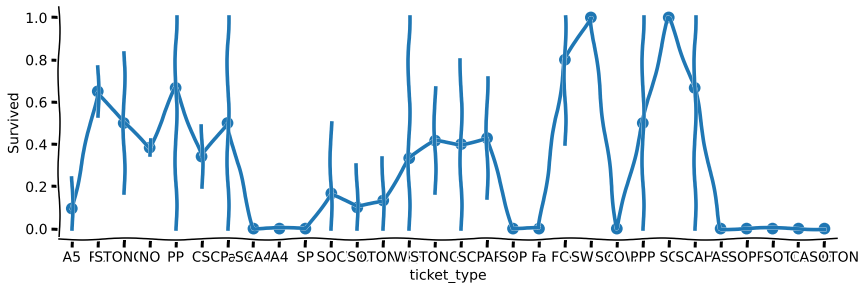

In [45]:
sns.factorplot('ticket_type','Survived', data=train,size=4,aspect=3)

# according to the plot there are too many ticket types that are not representative. 
# It happens because of too less unique values for each type

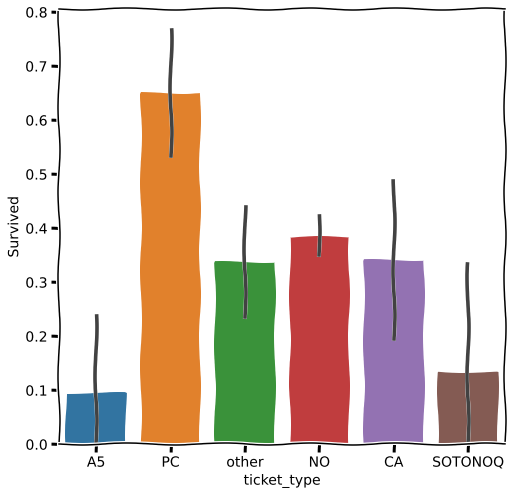

In [46]:
# for those types that have less than 15 samples in training set, assign type to 'OTHER':
# for train data create new column with ticket_type:
train = ticket_sep(train, True, False)

sns.barplot(x = 'ticket_type', y = 'Survived', data = train)
plt.show()

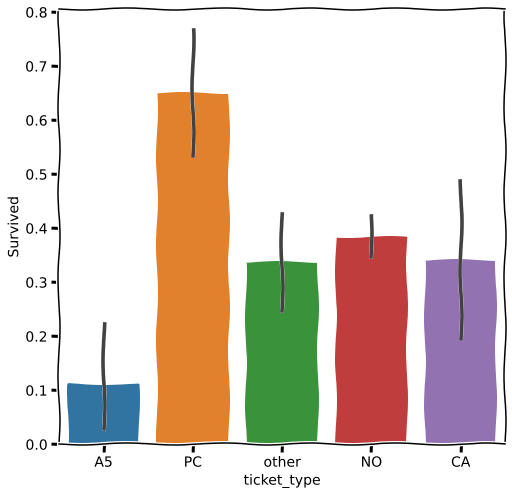

In [47]:
# From the plot it is visible that there is some pattern in probability of 
# survival based on ticket type:

# Passengers with PC ticket_type have higher probability to survive, and with A5 or SOTONOQ -
# lower probability to survive than average.
# As A5 and SOTONOQ have similar distributions and are 'rare' categories, we can combine then together

train = ticket_sep(train, True, True)

sns.barplot(x = 'ticket_type', y = 'Survived', data = train)
plt.show()

### 1.2.4 Cabin

In [48]:
# feature: 'Cabin' (Cabin number)
train["Cabin"].value_counts().index.tolist()[:5]

# comments
#Cabin:
# * cabin_type (letter before number) infomation is most probably related with deck. 
#   Hypothesis: People on lower deck could potentially have less probability to survive.
# * Cabin has also a lot of missing values. This can be also connected with survival rate. 
##  Hypothesis: people who did not survive could not provide information about cabin
# * Variable in column Cabin has following structure:
#   deck : Letter in front of number
#   cabin number Deck probably has impact on survival rate.

['B96 B98', 'G6', 'C23 C25 C27', 'F2', 'D']

In [49]:
import re

def get_deck(name):
    """Search for individual Capital letter inside a string associated to the cabin of a person, from  A-Z

    Parameters
    ----------
    name : The name from which a deck wants to be extracted (string)
    
    Returns
    -------
    Letter associated with the deck from that a person has
    """    
    if pd.isnull(name):
        return 'None'
    else:
        title_search = re.findall(r"^\w", name)
        # If the title exists, extract and return it.
        if title_search:
            return title_search[0]
        else:
            return 'None'

# e.g.
print("""Full testing name for function: '{}' """.format(train['Cabin'][3]))
print("""Definition used leads to: '{}' """.format(get_deck(train['Cabin'][3])))
# or 
print("")
# e.g.
print("""Full testing name for function: '{}' """.format(train['Cabin'][8]))
print("""Definition used leads to: '{}' """.format(get_deck(train['Cabin'][8])))

Full testing name for function: 'C123' 
Definition used leads to: 'C' 

Full testing name for function: 'nan' 
Definition used leads to: 'None' 


In [50]:
def get_decks(df, mod: bool = True):
    """Search for the information of all decks inside a dataframe, given the feature 'Cabin'

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    Original dataframe with a new feature called 'Deck'
    """
    df['Deck'] = df['Cabin'].apply(get_deck)
    # Modifications
    if mod: 
        for t in df['Deck'].unique():
            if len(df[df['Deck']==t]) <= 14:
                df.loc[df['Deck'] ==t, 'Deck'] = 'other'
        
    return df

# Create a new feature Title, containing the titles of passenger names
train = get_decks(train, False) # returns categories

None    687
C        59
B        47
D        33
E        32
A        15
F        13
G         4
T         1
Name: Deck, dtype: int64


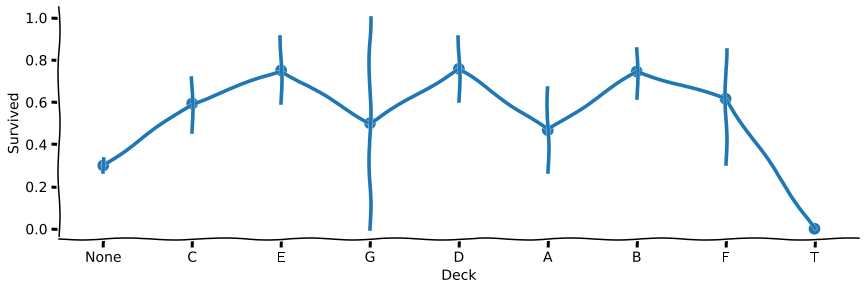

In [51]:
print(train["Deck"].value_counts())
sns.factorplot('Deck','Survived', data=train,size=4,aspect=3)
plt.show()

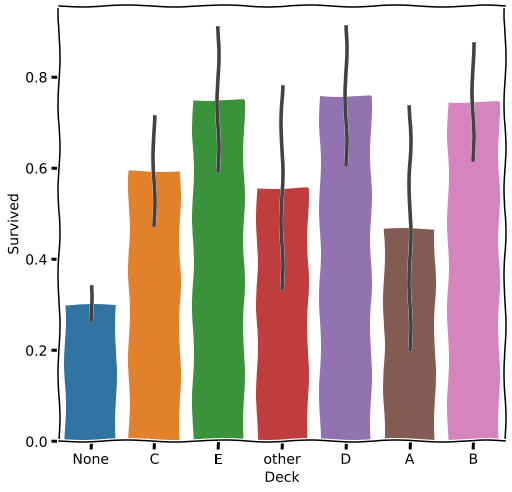

In [52]:
# Create a new feature Title, containing the titles of passenger names
train = get_decks(train, True) # returns categories

sns.barplot(x = 'Deck', y = 'Survived', data = train)
plt.show()

In [53]:
pd.DataFrame(train.groupby(['Deck'])['Survived'].mean()).sort_values(by='Survived', ascending=True).T

Deck,None,A,other,C,B,E,D
Survived,0.299854,0.466667,0.555556,0.59322,0.744681,0.75,0.757576


### 1.2.5 Embarked

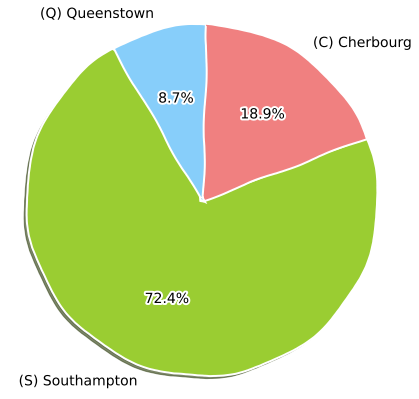

In [54]:
# feature: 'Embarked' (Port of Embarkation)
# C = Cherbourg, Q = Queenstown, S = Southampton
embk_dic  = {'C': "(C) Cherbourg", 'Q': "(Q) Queenstown", 'S': "(S) Southampton" }
sizes  = train["Embarked"].value_counts().values
labels = [embk_dic[i] for i in train["Embarked"].value_counts().index.tolist() ]
colors  = ['yellowgreen', 'lightcoral', 'lightskyblue', 'gold', 'purple', 'cyan', 'red' ]
# Plot
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=120)
plt.axis('equal')
plt.show()

# commnets:
# majority of people departed from Southampton --> is there any relation with class? 

In [55]:
train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [56]:
# Missing values
train[train['Embarked'].isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Fare_num,Title,Age_t,Age_ps,Age_t_num,Age_ps_num,ticket_type,Deck
61,62,1,1,"Icard, Miss. Amelie",female,0,0,113572,D,B28,NaN,A,80.0,Miss,C,C,38.0,38.0,NO,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,0,0,113572,D,B28,NaN,A,80.0,Mrs,D,D,62.0,62.0,NO,B


In [57]:
# Relate Embarked and Pclass
train.groupby(["Embarked", "Pclass"]).size()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
dtype: int64

In [58]:
def embarked_bayes(df, i):
    """Using Bayes Theorem, and based on 'Pclass', determine the probability of 'Embarked' for a person 
    given the possibilities S, C or Q.

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    String associated to the most likely port from where a passenger Embarked, given its Pclass
    """
    
    pclass_ = df['Pclass'].iloc[i]
    # P(s|1) = P(s)*P(1|S)/[ P(s)*P(1|s) + P(s)*P(1|s) + P(s)*P(1|s)] # probability that given the class 1, the person came from port S
    P_S, P_C, P_Q = df['Embarked'].value_counts()['S'], df['Embarked'].value_counts()['C'], \
                    df['Embarked'].value_counts()['Q']
    P_class_S = df['Embarked'][df['Pclass'] == pclass_].value_counts()['S']
    P_class_C = df['Embarked'][df['Pclass'] == pclass_].value_counts()['C']
    P_class_Q = df['Embarked'][df['Pclass'] == pclass_].value_counts()['Q']
    res = []
    P_S_class = (P_S * P_class_S) / ((P_S * P_class_S) + (P_C * P_class_C) + (P_Q * P_class_Q))
    res.append(P_S_class)
    P_C_class = (P_C * P_class_C) / ((P_S * P_class_S) + (P_C * P_class_C) + (P_Q * P_class_Q))
    res.append(P_C_class)
    P_Q_class = (P_Q * P_class_Q) / ((P_S * P_class_S) + (P_C * P_class_C) + (P_Q * P_class_Q))
    res.append(P_C_class)

    if sorted(res, reverse=True)[0] == P_S_class:
        return 'S'
    elif sorted(res, reverse=True)[0] == P_C_class:
        return 'C'
    elif sorted(res, reverse=True)[0] == P_Q_class:
        return 'Q'

def get_embarked_bayes(df):
    """Search for the Embarked information of passengers missing this data, based on its 'Pclass'

    Parameters
    ----------
    df : panda dataframe
    
    Returns
    -------
    Original dataframe with all missing values from the feature 'Embarked'
    """
    emb = []
    for i, Port in df.iterrows():
        if pd.isnull(Port['Embarked']):
            emb.append(embarked_bayes(df, i))
        else:
            emb.append(Port['Embarked'])
    # Update column
    df['Embarked'] = emb
    
    return df

# get missing Embarked
train = get_embarked_bayes(train) # returns categories

### 1.2.6 Additional

In [59]:
train['Cabin'][27:32]

27    C23 C25 C27
28            NaN
29            NaN
30            NaN
31            B78
Name: Cabin, dtype: object

In [60]:
train['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))[27:32]

27    3
28    0
29    0
30    0
31    1
Name: Cabin, dtype: int64

In [61]:
def get_number_cabins(df):
    
    df['number_cabins'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
    
    return df


train = get_number_cabins(train)

# 2. Transform categorical to numerical

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Name           891 non-null    object  
 4   Sex            891 non-null    object  
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Ticket         891 non-null    object  
 8   Fare           891 non-null    category
 9   Cabin          204 non-null    object  
 10  Embarked       891 non-null    object  
 11  FamilySize     891 non-null    category
 12  Fare_num       891 non-null    float64 
 13  Title          891 non-null    object  
 14  Age_t          891 non-null    category
 15  Age_ps         891 non-null    category
 16  Age_t_num      891 non-null    float64 
 17  Age_ps_num     891 non-null    floa

In [63]:
to_drop = ['PassengerId','Ticket', 'Cabin' ,'Name']

# remove no longer useful features
train = drop_features(train, to_drop)
train.head(1)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,FamilySize,Fare_num,Title,Age_t,Age_ps,Age_t_num,Age_ps_num,ticket_type,Deck,number_cabins
0,0,3,male,1,0,A,S,B,7.25,Mr,B,B,22.0,22.0,A5,None,0


# 3. Encoding

Performance of particular encoding strategy for categorical feratures depends on amount of instances and features in data set, variable type and chosen model.

There are multiple ways to perform encoding:

**One-hot encoding**:
keeps all information about variable, but create a lot of new features

**Binary encoding**:
keeps all information about variable, creates new dimensions, but less than one-hot encoder

**Ordinal numbering encoding**:
keeps semantical info about variable, but treats 2-1 as 3-2 and can be missleading, doesn't create new dimensions

**Frequency encoding**:
doesn't create new dimensions, but depends on frequency rather than relation with target and that can lead to wrong predictions

**Target guided encoding**: ordinal, mean, and probability ratio encoding, Weight of evidence:
creates monotonic relationship between variable and target, but can cause overfitting

All of this models have advantages and disadvantagies and performance of particular encoding strategy for categorical feratures depends on amount of instances and features in data set, variable type and chosen prediction model. For more information about this encoding strategies there are multiple research papers and useful tutorial for each of this strategies.

In [64]:
# natural
train['Fare'][:2]

0    A
1    D
Name: Fare, dtype: category
Categories (4, object): ['A' < 'B' < 'C' < 'D']

In [65]:
np.unique(train['Fare'])

array(['A', 'B', 'C', 'D'], dtype=object)

In [66]:
# inverted 
train['Deck'][:2]

0    None
1       C
Name: Deck, dtype: object

In [67]:
np.unique(train['Deck'])[::-1]

array(['other', 'None', 'E', 'D', 'C', 'B', 'A'], dtype=object)

In [68]:
# prob
train.groupby(['Deck'])['Survived'].mean()

Deck
A        0.466667
B        0.744681
C        0.593220
D        0.757576
E        0.750000
None     0.299854
other    0.555556
Name: Survived, dtype: float64

In [69]:
list(pd.DataFrame(train.groupby(['Deck'])['Survived'].mean()).sort_values(by='Survived', ascending=True).T.columns.values)

['None', 'A', 'other', 'C', 'B', 'E', 'D']

In [70]:
def get_ordered_elements(df, key, order: int = 1):
    """ordered by natural order, inverted order or by survived probability
    """
    if order == 1:
        res = np.unique(df[key])
    if order == 2:
        res = np.unique(df[key])[::-1]
    elif order == 3:
        res = pd.DataFrame(df.groupby([key])['Survived'].mean()).sort_values(by='Survived', ascending=True).T.columns.values
    
    return res
    
def get_feature_to_numerical(df, key, elements):
    
    df[key] = df[key].apply(lambda x: list(elements).index(x))
    df[key] = df[key].astype(int)
    
    return df

train = get_feature_to_numerical(train, 'FamilySize', get_ordered_elements(train,'FamilySize', 1)) # cat to num
train = get_feature_to_numerical(train, 'Fare', get_ordered_elements(train,'Fare', 1)) # cat to num
train = get_feature_to_numerical(train, 'Age_t', get_ordered_elements(train,'Age_t', 1)) # cat to num
train = get_feature_to_numerical(train, 'Age_ps', get_ordered_elements(train,'Age_ps', 1)) # cat to num
train = get_feature_to_numerical(train, 'Title', get_ordered_elements(train,'Title')) # cat to num # hot
train = get_feature_to_numerical(train, 'Sex', get_ordered_elements(train,'Sex')) # cat to num # hot
train = get_feature_to_numerical(train, 'Deck', get_ordered_elements(train,'Deck', 2)) # cat to num
train = get_feature_to_numerical(train, 'Embarked', get_ordered_elements(train,'Embarked')) # cat to num # hot
train = get_feature_to_numerical(train, 'ticket_type', get_ordered_elements(train,'ticket_type')) # cat to num # hot

train.head(1)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,FamilySize,Fare_num,Title,Age_t,Age_ps,Age_t_num,Age_ps_num,ticket_type,Deck,number_cabins
0,0,3,1,1,0,0,2,1,7.25,2,1,1,22.0,22.0,0,1,0


# 4. Correlations

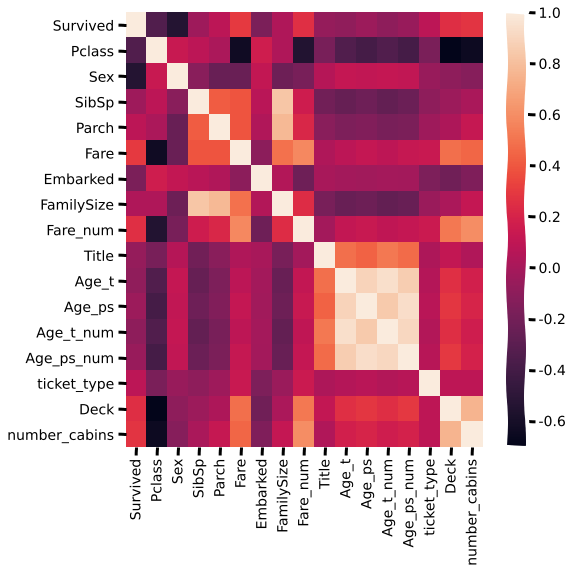

In [71]:
# ref: https://likegeeks.com/python-correlation-matrix/
correlation_mat = train.corr() # Compute Pearson’s correlation coefficient

# ** A large positive value (near to 1.0) indicates a strong positive correlation, i.e., if the value of 
# one of the variables increases, the value of the other variable increases as well
# ** A large negative value (near to -1.0) indicates a strong negative correlation, i.e., the value of one 
# variable decreases with the other’s increasing and vice-versa
# ** A value near to 0 (both positive or negative) indicates the absence of any correlation 
# between the two variables, and hence those variables are independent of each other

plt.figure(figsize=(8,8))
sns.heatmap(correlation_mat, annot = False)
plt.show()

# coments
# Pclass and Fare seems to be slightly anti-correlated
# Sex and survival are quite correlated

# 5. Further Features Engineering 

In [72]:
def get_extra_features(df):
    
    # Extra correlations
    df['Fare_Sex']       = df['Fare']   * df['Sex']
    df['Pclass_Sex']     = df['Pclass'] * df['Sex']
    df['Pclass_Title']   = df['Pclass'] * df['Title']
    df['Title_Sex']      = df['Title']  * df['Sex']
    df['Title_Pclass']   = df['Title']  * df['Pclass']
    df['Emb_Pclass']     = df['Pclass'] * df['Embarked']
    
    return df

# Extra correlations
train = get_extra_features(train)

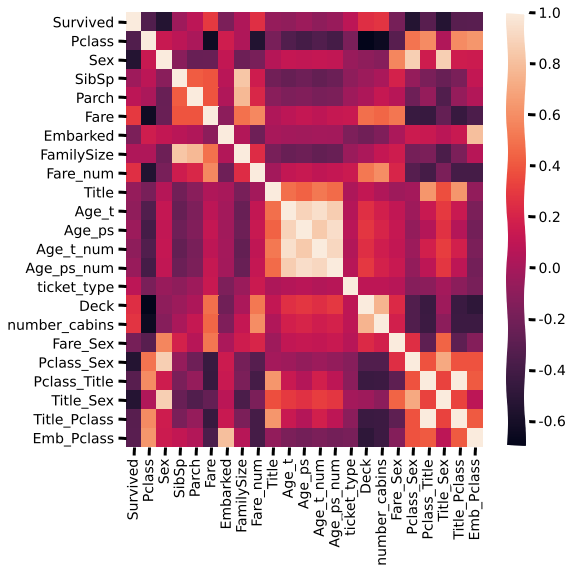

In [73]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(), annot = False)
plt.show()

In [74]:
# extra ref
# # https://www.kaggle.com/volhaleusha/titanic-tutorial-encoding-feature-eng-81-8#Part-5:-Explore-and-Engineer-Features